# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set(style="darkgrid")
warnings.simplefilter('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

### Изучение данных из файла

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=df, 
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name', 
                                                   y_col='real_age', 
                                                   target_size=(224, 224), 
                                                   batch_size=16, 
                                                   class_mode='raw', 
                                                   seed=244466666)

Found 7591 validated image filenames.


In [ ]:
print('Размер датафрейма:', df.shape[0])

Размер датафрейма: 7591


In [ ]:
df.sample(10)

,file_name,real_age
5219,005219.jpg,32
3654,003654.jpg,32
5190,005190.jpg,29
6172,006175.jpg,41
3486,003486.jpg,30
5904,005905.jpg,38
2178,002178.jpg,50
1219,001219.jpg,25
1418,001418.jpg,40
579,000579.jpg,33


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


### Распределение возраста на графике

[Text(0.5, 1.0, 'Распределение возраста'), Text(0.5, 0, 'Возраст')]

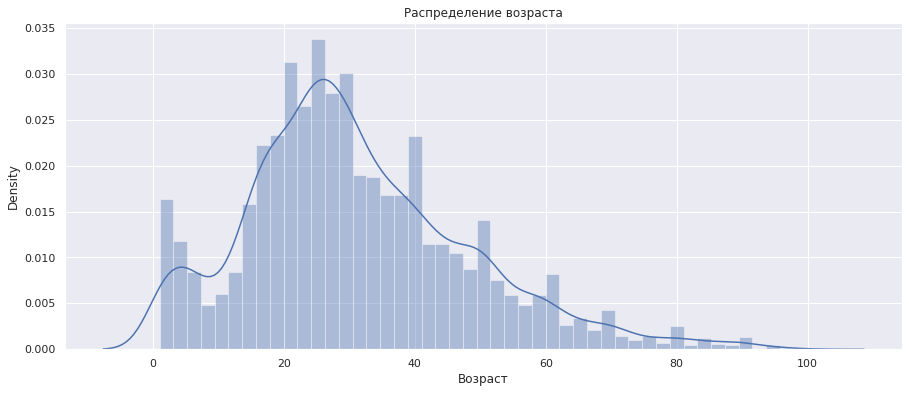

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = sns.distplot(df['real_age'])
ax.set(title='Распределение возраста', xlabel='Возраст')

Распередение похоже на нормальное. Пик раблюдается на значении около 24 лет. Основная масса людей в возрасте от 16 до 40 лет.

### Печать фотографий

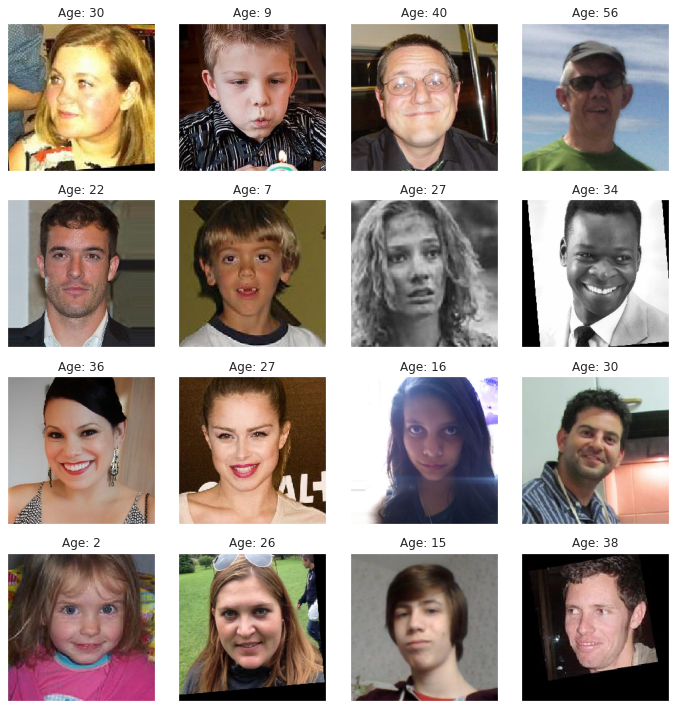

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

В выборке достаточно разнообразные изображения
Есть мужчины, женщины, дети, все разных возрастов. Также есть чёрно белые фотографии, фото с шумом и фотографии, на которых лицо занимает меньше 20% площади, что затрудняет предсказания модели.

## Обучение модели

За основу была взята модель ResNet50, с ипользованием весов imagenet.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=244466666)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25, horizontal_flip=True)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=244466666)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape, weights='imagenet', include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

```

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-05-13 17:19:22.467181: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-13 17:19:25.558594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 116s - loss: 201.8550 - mae: 10.5253 - val_loss: 407.0953 - val_mae: 15.1053
Epoch 2/10
178/178 - 37s - loss: 97.7886 - mae: 7.4894 - val_loss: 437.6658 - val_mae: 15.7686
Epoch 3/10
178/178 - 37s - loss: 66.8768 - mae: 6.1990 - val_loss: 374.1850 - val_mae: 14.2479
Epoch 4/10
178/178 - 37s - loss: 44.7346 - mae: 5.1249 - val_loss: 194.5280 - val_mae: 10.4315
Epoch 5/10
178/178 - 37s - loss: 30.7965 - mae: 4.2561 - val_loss: 136.1175 - val_mae: 8.6798
Epoch 6/10
178/178 - 37s - loss: 22.8725 - mae: 3.7201 - val_loss: 83.2892 - val_mae: 6.9067
Epoch 7/10
178/178 - 37s - loss: 16.7320 - mae: 3.1524 - val_loss: 76.1334 - val_mae: 6.5484
Epoch 8/10
178/178 - 37s - loss: 13.5376 - mae: 2.8163 - val_loss: 69.3975 - val_mae: 6.2527
Epoch 9/10
178/178 - 37s - loss: 10.1630 - mae: 2.4263 - val_loss: 81.6620 - val_mae: 7.0067
Epoch 10/10
178/178 - 37s - loss: 8.8409 - mae: 2.2674 - val_loss: 76.1458 - val_mae: 6.6986
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 76.1458 - mae: 6.6986
Test MAE: 6.6986


```

## Анализ обученной модели

В результате работы была получена метрика MAE ниже 7. Данную нейросеть вполне можно использовать для решения бизнес задачи, так как метрика MAE удовлетворяет требованиям, поставленным заказчиком.